In [39]:
import gower
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import importlib
import seaborn as sns
from sklearn.metrics import rand_score, adjusted_rand_score
import sys
import os
## import tSNE

In [40]:
## import custom scripts
sys.path.append(os.path.abspath(os.path.join('scripts')))
import preprocessing
import autoencoder_detection
import isolation_forest_detection
import lof_detection
import knn_detection
import dbscan_detection
import pca_detection
import utils

importlib.reload(utils)
importlib.reload(lof_detection)
importlib.reload(autoencoder_detection)
importlib.reload(preprocessing)
importlib.reload(isolation_forest_detection)
importlib.reload(knn_detection)
importlib.reload(dbscan_detection)
importlib.reload(pca_detection)

<module 'pca_detection' from '/home/ronin/Dev/notebooks/machinelearningformodeling/unsupervised/project/scripts/pca_detection.py'>

In [41]:
df = preprocessing.load_dataset()
dm = gower.gower_matrix(df)

In [5]:
## validation dataset
# df = pd.read_csv('data/data2_preprocessed.csv')
# true_labels =  df.iloc[:,-1]
# df = df.iloc[:, :-1]
# dm = gower.gower_matrix(df)
# np.sum(true_labels == -1)

In [27]:
pca_indices = pca_detection.main(distance_matrix=dm)
pd.DataFrame(pca_indices).value_counts()

PCA: explained variation per principal component: [0.55993 0.27381 0.06283 0.02981 0.02188 0.01664 0.01021 0.00602]


 0    6829
-1     371
Name: count, dtype: int64

In [28]:
dbscan_indices = dbscan_detection.main(distance_matrix=dm)
pd.DataFrame(dbscan_indices).value_counts()

 0    6862
-1     338
Name: count, dtype: int64

In [29]:
# Importing the dataset
lof_indices = lof_detection.main(distance_matrix=dm)
pd.DataFrame(lof_indices).value_counts()

 0    6840
-1     360
Name: count, dtype: int64

In [43]:
autoencoder_indices = np.array(autoencoder_detection.main(dataframe=df))
#print(adjusted_rand_score(isolation_forest_indices, autoencoder_indices))
pd.DataFrame(autoencoder_indices).value_counts()

Epoch [1/50], Loss: 0.1106, LR: 0.01
Epoch [11/50], Loss: 0.0259, LR: 0.01
Epoch [21/50], Loss: 0.0327, LR: 0.01
Epoch [31/50], Loss: 0.0272, LR: 0.005
Epoch [41/50], Loss: 0.0060, LR: 0.005
Training complete
treshold is: 0.1015
percentage of outliers is:  4.97%


 0    6842
-1     358
Name: count, dtype: int64

In [11]:
isolation_forest_indices = pd.DataFrame(isolation_forest_detection.main(dataframe=df)).replace({1:0}).to_numpy()[:,0]
pd.DataFrame(isolation_forest_indices).value_counts()

 0    6840
-1     360
Name: count, dtype: int64

In [12]:
knn_indices = np.array(knn_detection.main(distance_matrix=dm))
pd.DataFrame(knn_indices).value_counts()

knee = 0.05163099989295006


 0    6882
-1     318
Name: count, dtype: int64

In [13]:
tot_indices = (lof_indices + 
                autoencoder_indices +  
                isolation_forest_indices + 
                knn_indices + 
                dbscan_indices +
                pca_indices)
tot_indices = -1 * tot_indices

In [14]:
comparison = pd.DataFrame()
comparison['tot_indices'] = -1 * (tot_indices >= 4)
comparison['lof_indices'] = lof_indices
comparison['autoencoder_indices'] = autoencoder_indices
comparison['isolation_forest_indices'] = isolation_forest_indices
comparison['knn_indices'] = knn_indices
comparison['dbscan_indices'] = dbscan_indices
comparison['pca_indices'] = pca_indices
np.sum(comparison, axis = 0) * -1

tot_indices                 305
lof_indices                 360
autoencoder_indices         465
isolation_forest_indices    360
knn_indices                 318
dbscan_indices              338
pca_indices                 371
dtype: int64

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6916 samples in 0.023s...
[t-SNE] Computed neighbors for 6916 samples in 0.317s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6916
[t-SNE] Computed conditional probabilities for sample 2000 / 6916
[t-SNE] Computed conditional probabilities for sample 3000 / 6916
[t-SNE] Computed conditional probabilities for sample 4000 / 6916
[t-SNE] Computed conditional probabilities for sample 5000 / 6916
[t-SNE] Computed conditional probabilities for sample 6000 / 6916
[t-SNE] Computed conditional probabilities for sample 6916 / 6916
[t-SNE] Mean sigma: 0.000038
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.131645
[t-SNE] KL divergence after 1000 iterations: 0.644140


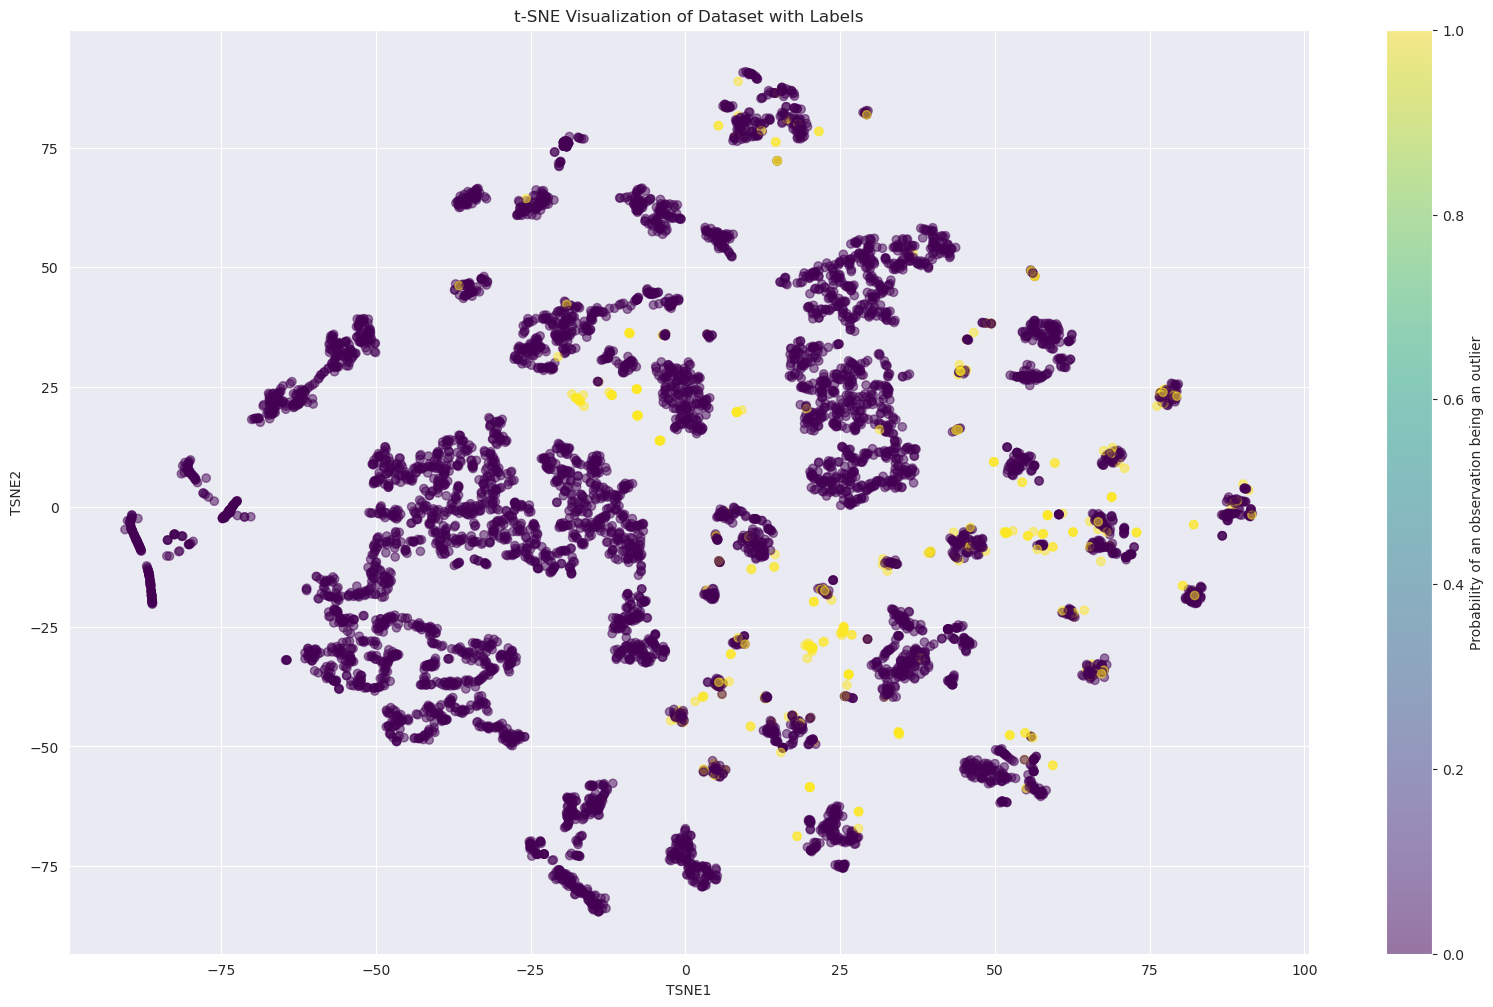

In [124]:
outl_probs = list(map(utils.sigmoid_to_prob(k=6), autoencoder_indices * -6))
outl_probs = list(map(lambda x: x/6, outl_probs))

utils.plot_TSNE_2(dist_matrix= dm, labels=outl_probs)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6916 samples in 0.025s...
[t-SNE] Computed neighbors for 6916 samples in 0.319s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6916
[t-SNE] Computed conditional probabilities for sample 2000 / 6916
[t-SNE] Computed conditional probabilities for sample 3000 / 6916
[t-SNE] Computed conditional probabilities for sample 4000 / 6916
[t-SNE] Computed conditional probabilities for sample 5000 / 6916
[t-SNE] Computed conditional probabilities for sample 6000 / 6916
[t-SNE] Computed conditional probabilities for sample 6916 / 6916
[t-SNE] Mean sigma: 0.000038
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.934441
[t-SNE] KL divergence after 1000 iterations: 0.635132


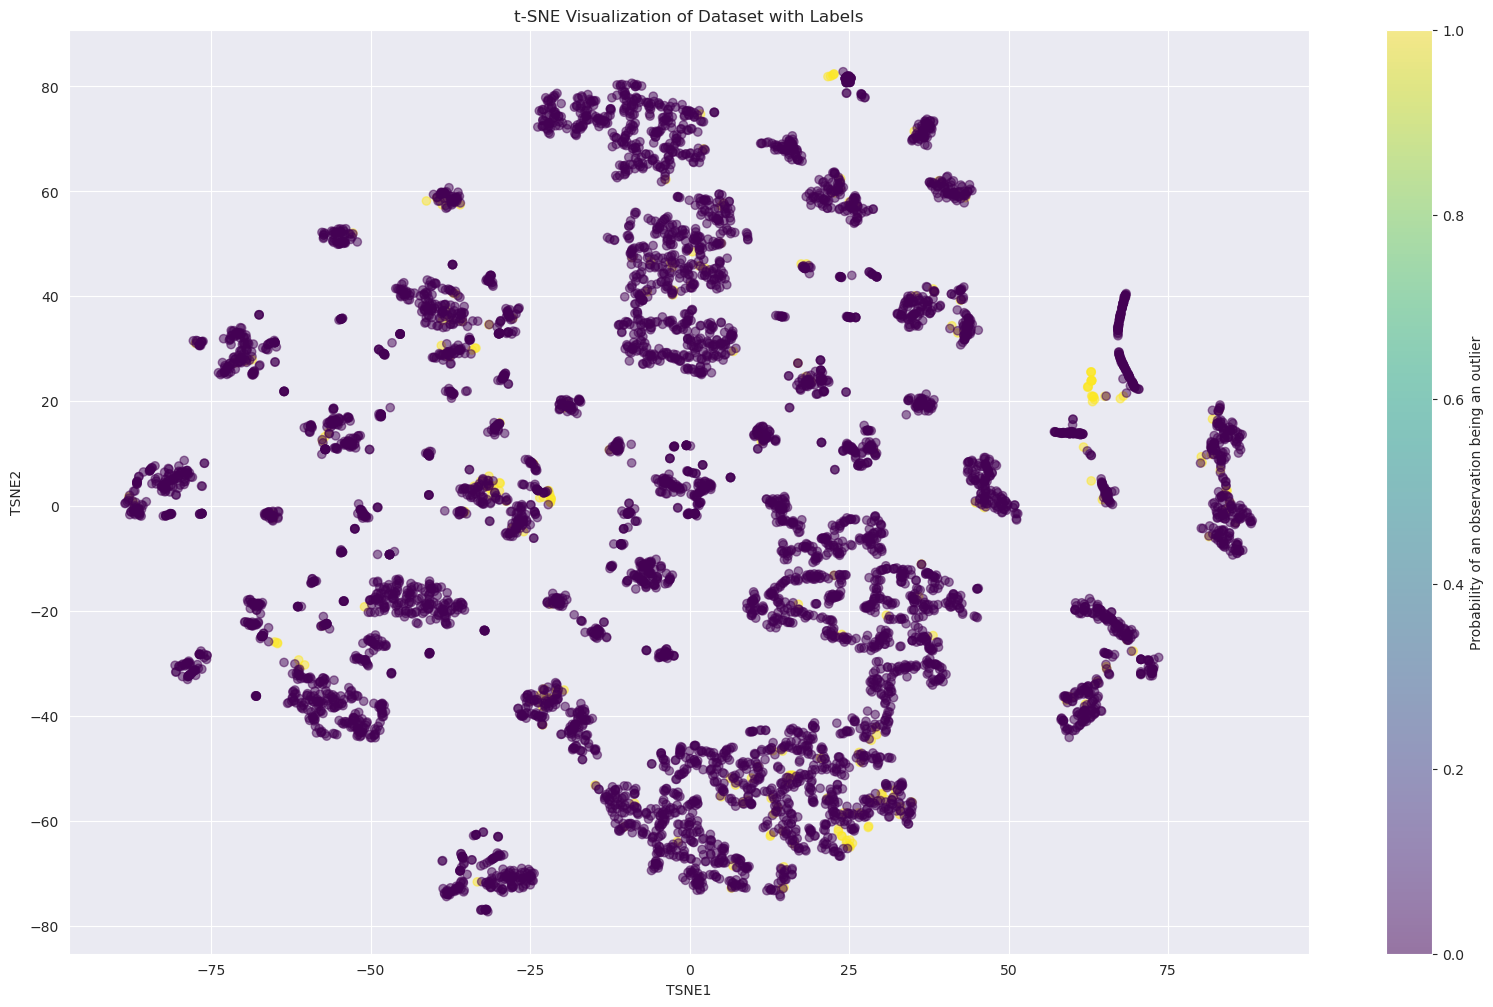

In [41]:
utils.plot_TSNE_2(dist_matrix= dm, labels= np.array(true_labels) * -1)

In [38]:
#np.save('results.npy', outl_probs)

In [112]:
utils.plot_3d_TSNE(df=None, 
                labels=true_labels, 
                dist_matrix=dm,)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6916 samples in 0.023s...
[t-SNE] Computed neighbors for 6916 samples in 0.401s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6916
[t-SNE] Computed conditional probabilities for sample 2000 / 6916
[t-SNE] Computed conditional probabilities for sample 3000 / 6916
[t-SNE] Computed conditional probabilities for sample 4000 / 6916
[t-SNE] Computed conditional probabilities for sample 5000 / 6916
[t-SNE] Computed conditional probabilities for sample 6000 / 6916
[t-SNE] Computed conditional probabilities for sample 6916 / 6916
[t-SNE] Mean sigma: 0.000038
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.229267
[t-SNE] KL divergence after 1000 iterations: 0.532202


In [14]:
non_out = tot_indices == 0

In [15]:
out = tot_indices > 2

In [16]:
np.abs(np.sum(df[non_out].iloc[:,utils.binary_indices] - 1, axis=1)).describe()

count    6288.000000
mean        0.664599
std         0.642045
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         2.000000
dtype: float64

In [17]:
np.abs(np.sum(df[out].iloc[:,utils.binary_indices] - 1, axis=1)).describe()

count    346.000000
mean       2.436416
std        0.657402
min        1.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        5.000000
dtype: float64

In [55]:
list_of_indices =   [lof_indices,
                     autoencoder_indices ,
                    isolation_forest_indices,
                    knn_indices,
                    dbscan_indices,
                    pca_indices,
                    true_labels.to_numpy()]
method_names =  ["lof",
                 "autoencoder",
                "isolation_forest",
                "knn",
                "dbscan",
                "pca",
                 "true_labels"]

In [49]:
jaccard = utils.jaccard_index(-1) ## returns a callable function
def compute_rand_indices(label_lists):
    n = len(label_lists)
    rand_indices = np.zeros((n, n))
    for i in range(n):
        for j in range(i,n): # it is symmetric, i am just computing half
            score = adjusted_rand_score(label_lists[i], label_lists[j])
            #score = rand_score(label_lists[i], label_lists[j])
            #score = jaccard(label_lists[i], label_lists[j])
            rand_indices[i, j] = score
            rand_indices[j, i] = score
            
    
    return rand_indices

def plot_heatmap(matrix, labels):
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, xticklabels=labels, yticklabels=labels, annot=True, cmap="viridis", vmin=0)
    plt.title('Rand Index Heatmap')
    plt.show()

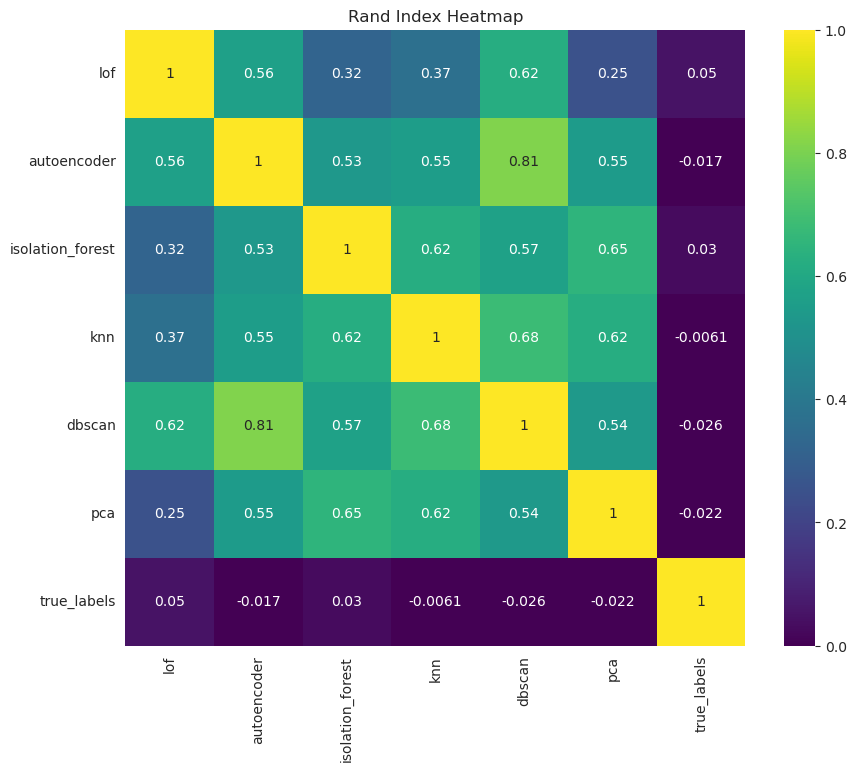

In [50]:
plot_heatmap(compute_rand_indices(list_of_indices), labels=method_names)

In [56]:
label_lists = list_of_indices
n = len(label_lists)
for i in range(n):
    for j in range(i,n): # it is symmetric, i am just computing half
        print(f"adj_rand = {adjusted_rand_score(label_lists[i], label_lists[j])}, jaccard = {jaccard(label_lists[i], label_lists[j])}")
    

adj_rand = 1.0, jaccard = 1.0
adj_rand = 0.562658661262258, jaccard = 0.4369747899159664
adj_rand = 0.3191706242984101, jaccard = 0.2313167259786477
adj_rand = 0.3667698827388831, jaccard = 0.25740318906605925
adj_rand = 0.6241979852282241, jaccard = 0.49777777777777776
adj_rand = 0.2515997840629744, jaccard = 0.17857142857142858
adj_rand = 0.04963631350481348, jaccard = 0.04929577464788732
adj_rand = 1.0, jaccard = 1.0
adj_rand = 0.5345486580591338, jaccard = 0.41030927835051545
adj_rand = 0.5523447252278645, jaccard = 0.4166666666666667
adj_rand = 0.8086455699875851, jaccard = 0.712082262210797
adj_rand = 0.5459726972491571, jaccard = 0.41647597254004576
adj_rand = -0.016857481271794945, jaccard = 0.012048192771084338
adj_rand = 1.0, jaccard = 1.0
adj_rand = 0.6233230791901321, jaccard = 0.48787061994609165
adj_rand = 0.5730391602163942, jaccard = 0.44635193133047213
adj_rand = 0.6501230318746634, jaccard = 0.5218446601941747
adj_rand = 0.03034550732138964, jaccard = 0.03832752613240

In [21]:
for i in range(7):
    r =  rand_score(-1*(tot_indices >= i), true_labels.to_numpy())
    ar = adjusted_rand_score(-1 * (tot_indices) >= i, true_labels.to_numpy())
    print(f'For {i}, Rand score  is {r:.3f}, Adjusted Rand score {ar:.3f}')

For 0, Rand score  is 0.930, Adjusted Rand score 0.049
For 1, Rand score  is 0.799, Adjusted Rand score 0.000
For 2, Rand score  is 0.828, Adjusted Rand score 0.000
For 3, Rand score  is 0.845, Adjusted Rand score 0.000
For 4, Rand score  is 0.872, Adjusted Rand score 0.000
For 5, Rand score  is 0.892, Adjusted Rand score 0.000
For 6, Rand score  is 0.916, Adjusted Rand score 0.000


In [22]:
comparison['true_labels'] = true_labels

In [23]:
comparison['true_labels'].value_counts()

true_labels
 0    6666
-1     250
Name: count, dtype: int64

In [24]:
comparison = comparison.replace({-1: 1})
np.sum(comparison, axis = 0)

true_labels                 250
tot_indices                 234
lof_indices                 346
autoencoder_indices         338
isolation_forest_indices    346
knn_indices                 206
dtype: int64

In [25]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc

# Assuming `true_labels` are the true labels (0 for non-anomaly, 1 for anomaly)
# and `predicted_labels` are the predicted labels from your model
true_labels = comparison['true_labels']
predicted_labels = comparison['tot_indices']

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
print(f'Confusion Matrix:\n{cm}')

# Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy}')

# Precision
precision = precision_score(true_labels, predicted_labels)
print(f'Precision: {precision}')

# Recall
recall = recall_score(true_labels, predicted_labels)
print(f'Recall: {recall}')

# F1 Score
f1 = f1_score(true_labels, predicted_labels)
print(f'F1 Score: {f1}')

# ROC-AUC
roc_auc = roc_auc_score(true_labels, predicted_labels)
print(f'ROC-AUC: {roc_auc}')

# Precision-Recall AUC
precision_vals, recall_vals, _ = precision_recall_curve(true_labels, predicted_labels)
pr_auc = auc(recall_vals, precision_vals)
print(f'Precision-Recall AUC: {pr_auc}')


Confusion Matrix:
[[6437  229]
 [ 245    5]]
Accuracy: 0.9314632735685368
Precision: 0.021367521367521368
Recall: 0.02
F1 Score: 0.02066115702479339
ROC-AUC: 0.4928232823282328
Precision-Recall AUC: 0.03839631129104813


In [26]:
np.sum(tot_indices >= 4)

234

In [27]:
rand_score(true_labels, np.zeros(len(true_labels)))

0.9303071628679574